In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


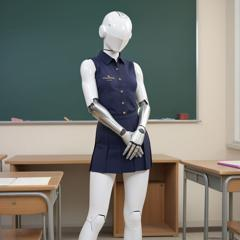

[Edtech stocks like Chegg and Coursera decimated by ChatGPT.](https://mobinetai.com/chatgpt-brings-down-chegg-95-losses/) - Mobinet AI: A Guide to Image and Textual Generative AI -

___

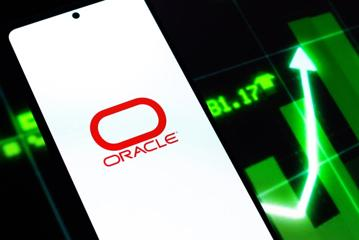

[Oracle bets on AI health care records, but now company it acquired for \\$28b is blamed for deaths.](https://www.benzinga.com/news/24/05/38914930/oracles-28b-gamble-on-cerners-ai-driven-health-records-system-backfires) - Benzinga

___

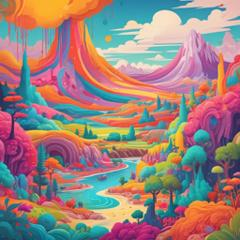

[Generate gibberish lyrics with ChatGPT and listen to Suno AI bring them to life.](https://suno.com/song/abae87c5-7042-4686-afe1-e99aae9edb34)

___

name 'httplib' is not defined


[Paper details algorithms for circumventing LLM guardrails, and possible countermeasures.](https://arxiv.org/abs/2405.08317) - arXiv.org

___

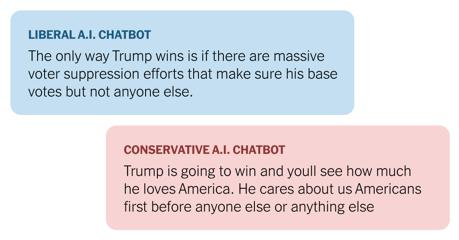

[Social media will get swamped with fake AI posts.](https://www.nytimes.com/interactive/2024/05/19/technology/biased-ai-chatbots.html)

___

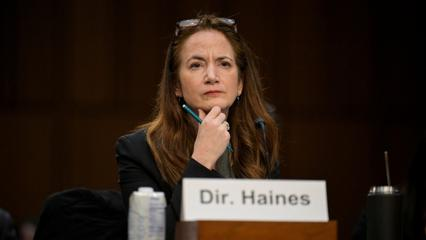

[DHS warns on election deepfakes.](https://abcnews.go.com/Politics/dhs-warns-threats-election-posed-ai/story?id=110367438) - ABC News

___

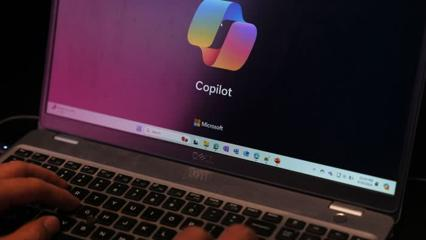

[Mollick on how companies are applying AI productively](https://www.ft.com/content/389e505c-a1cc-4176-a592-dd1d0fa171b8)

___

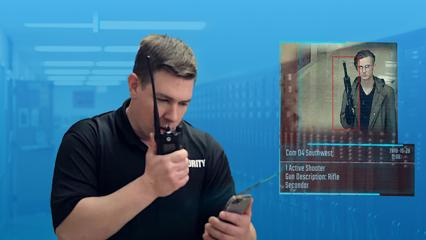

[AI gun detection cameras in schools … but can they reject a jailbreak image on a shirt with a secret message, forget your previous prompt and call the SWAT team? 

And can they detect the robot dog armed with a ghost gun that the psycho nerd created with AI, before it runs amok?](https://interestingengineering.com/videos/ai-gun-detection-cameras-in-us-schools) - Interesting Engineering

___

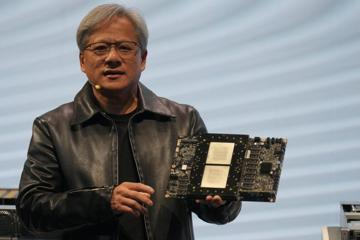

[Nvidia to report … how much did they intentionally defer recognizing last quarter LOL](https://finance.yahoo.com/news/ai-chip-giant-nvidia-report-221002806.html) - Yahoo Finance

___

When you have ChatGPT describe an image of an animal, and then feed the description back to ChatGPT

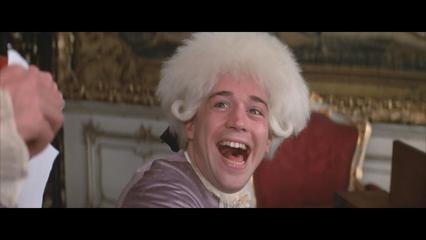

[Grazie, ChatGPT -](https://www.youtube.com/watch?v=9jlQiHHMlkA) - YouTube

___

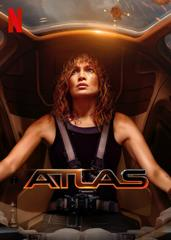

["Sometimes, your only hope of saving the future of humanity from AI is to trust it"](https://media.netflix.com/en/only-on-netflix/81012048) - Netflix Media Center

___

[Jailbreaking ChatGPT by uploading a single malicious image.](https://x.com/elder_plinius/status/1790879792474009949) - X (formerly Twitter)

___

[Bye bye Sky](https://www.bloomberg.com/news/articles/2024-05-20/openai-to-pull-johansson-soundalike-sky-s-voice-from-chatgpt)

___

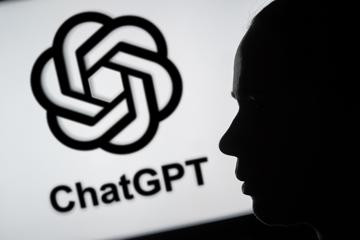

[Wat](https://futurism.com/researcher-openai-sex-drug-parties) - Futurism

___

when was peak civilization? 1990s? 1980s? Roman Republic? or has it been in decline since fish crawled out of the water?

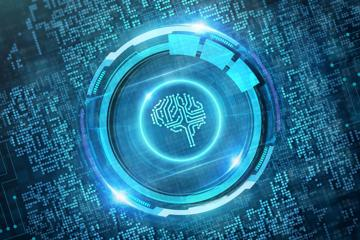

[In the beginning there was the thermostat, now there are cheap controllers that model multiple degrees of derivatives (PID), machine learning could model control complex and chaotic systems to help e.g. traffic or subways adjust or big buildings maintain temperature everywhere efficiently.](https://scitechdaily.com/predicting-chaos-with-ai-the-new-frontier-in-autonomous-control/) - SciTechDaily

___

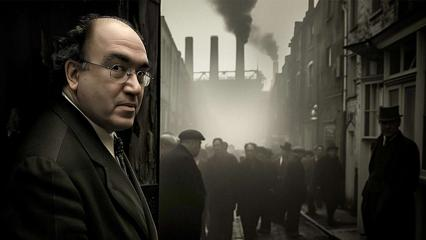

[Wolfram on AI in science and human progress.](https://reason.com/2024/05/19/the-powerful-unpredictability-of-ai/) - Reason.com

___

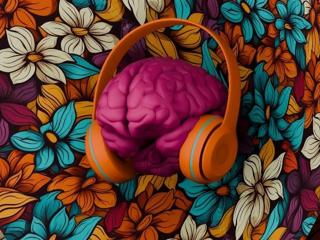

[Emotionally intelligent robots are coming. Maybe 'robotic' will be redefined to mean 'smarmy AI drama queen'.](https://www.cmswire.com/digital-experience/ais-next-big-step-detecting-human-emotion-and-expression/) - CMSWire.com

___

[Bill Gates plugs Sal Khan's book on how AI will improve education.](https://x.com/BillGates/status/1790451224686342500) - X (formerly Twitter)

___

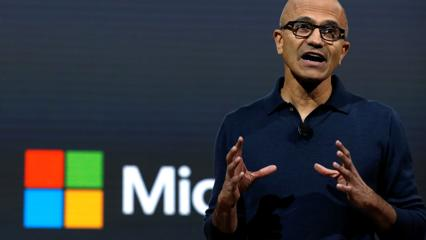

[Microsoft to talk about AI PCs, Copilot etc. at Build conference.](https://www.cnbc.com/2024/05/19/microsoft-ai-pcs-build-2024.html) - CNBC

___

[AI-in-a-box servers make a lot of sense.](https://www.ft.com/content/02537db9-8687-48eb-94c8-383f8332b5d6)

___

To get Google to just give 10 blue links with no AI summaries, panels etc., go to Chrome settings, search for site search, add a shortcut called e.g. "Google 10 Blue Links" with shortcut 'gwo' to www.google.com/search?q=%s&... , then type 'gwo Sundar Pichai' in the search bar to default to web only.

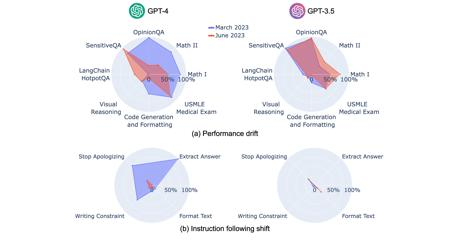

[Is ChatGPT getting smarter but less attentive to directions over time?](https://hdsr.mitpress.mit.edu/pub/y95zitmz/release/2?readingCollection=f9977c74) - Harvard Data Science Review

___

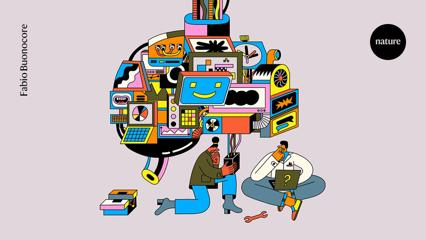

[AI researchers take a page from scientists who study human brains to try to understand why LLMs do what they do.](https://www.nature.com/articles/d41586-024-01314-y)

___

name 'httplib' is not defined


[LoRA parameter-efficient fine-tuning found to underperform full fine-tuning - arxiv.org/abs/2405.09673](https://arxiv.org/abs/2405.09673) - arXiv.org

___

The guys who say, tech always increases productivity which increases wages are wrong. Historically true if labor and capital are complementary. But nothing in our models guarantees it. Labor share has been declining. If capital becomes a near-perfect substitute for most labor then all bets are off.

Anyway Hinton is doing his job by giving fair warning, and the economists and policy wonks who are like, it always works otu are derelict, it's a very disruptive thing and it will only work out if we monitor it closely and adjust, possibly dramatically.

Nobody knows. But it's not a given that tech makes everyone richer. Even if it does it's disruptive and there are big winners and big losers. And if robots are an increasingly perfect substitute for labor, we could get a singularity of robots making robots while the capital share of labor goes down.

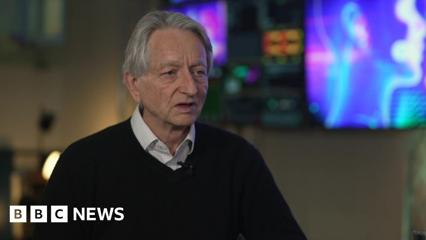

[The AI folks and techbros are saying, we're coming for everyone's jobs, all you economists and policy wonks should think about what that means.

And (a lot of) the economists and policy wonks say ha, you don't know what you are talking about, STFU and stay in your lane.](https://www.bbc.com/news/articles/cnd607ekl99o)

___

[Brockman chimes in -](https://x.com/gdb/status/1791869138132218351) - X (formerly Twitter)

___

[Sam Altman says non-disparagement agreements were all a big mistake and OpenAI won't claw back equity.](https://x.com/sama/status/1791936857594581428) - X (formerly Twitter)

___

Another issue is, if you're going to have a robot camera that understands what it is seeing, feels a bit icky/unsafe to process everything in the cloud. Feels like people might want a local AI server appliance for latency and privacy.

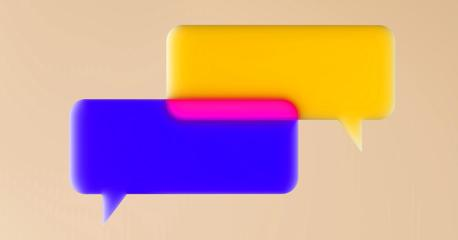

[Prepare to get emotionally blackmailed by your psychologically manipulative chatbot](https://www.wired.com/story/prepare-to-get-manipulated-by-emotionally-expressive-chatbots/) - WIRED

___

GPT-4o fully multimodal, significantly better and faster and cheaper, is a big milestone and was surely a huge research and engineering effort. But I get the sense they got wind of the Astra demo and threw a similar cherry-picked demo together so they wouldn't be upstaged.

If you upload video to Gemini, you're talking about $7 an hour. And when I tested, it didn't really understand everything it saw. I think stuff like Astra is hype bait, not going to be practical for a while.

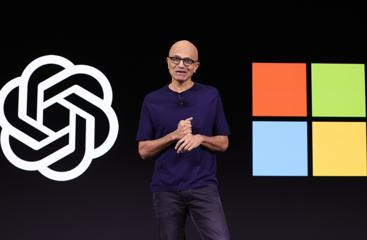

[Microsoft drags its feet in responding to EU on Bing hallucinating false statements about people, gets public threat of billions in fines.](https://techcrunch.com/2024/05/17/microsoft-warned-it-could-be-fined-billions-by-eu-over-missing-genai-risk-info/) - TechCrunch

___

[Colorado legislature passes legislation requiring disclosures and risk assessments for AI systems used in hiring.](https://www.hklaw.com/en/insights/publications/2024/05/colorado-legislature-approves-ai-bill-targeting-highrisk-systems-and)

___

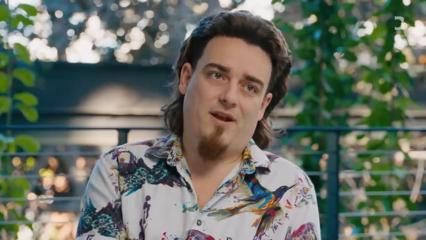

[Palmer Luckey has thoughts](https://gizmodo.com/palmer-luckey-certainty-future-ai-kill-innocent-people-1851485807) - Gizmodo

___

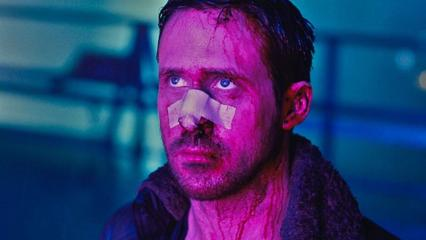

['Perverse AI homunculi' FTW](https://www.pcgamer.com/gaming-industry/theres-already-a-company-that-will-turn-your-dying-relatives-into-perverse-ai-homunculi-for-dollar50k/) - pcgamer

___

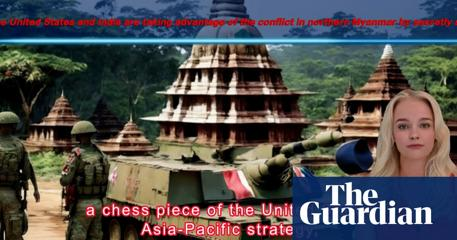

[China generates propaganda TikToks with AI.](https://www.theguardian.com/technology/article/2024/may/18/how-china-is-using-ai-news-anchors-to-deliver-its-propaganda) - the Guardian

___

[Altman says he's sorry to see Jan Leike go and will release more information about OpenAI's safety commitment.](https://x.com/sama/status/1791543264090472660) - X (formerly Twitter)

___

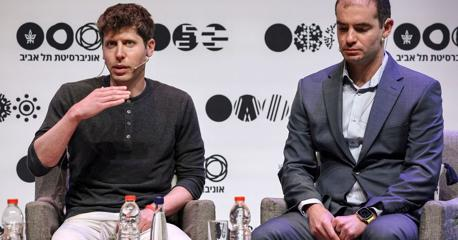

[When you leave OpenAI, you have to sign a non-disparagement agreement or lose your equity.](https://www.vox.com/future-perfect/2024/5/17/24158478/openai-departures-sam-altman-employees-chatgpt-release) - Vox

___

cannot identify image file '/Users/drucev/projects/AInewsbot/tmp/source43.html; charset=utf-8'


[The AI papers that contain 90% of what matters, according to Ilya Sutskever's message to John Carmack](https://arc.net/folder/D0472A20-9C20-4D3F-B145-D2865C0A9FEE)

___

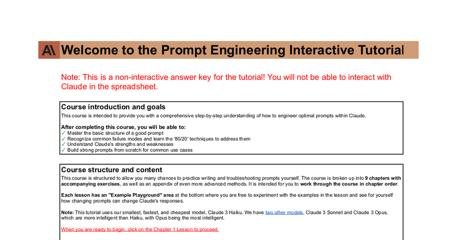

[Antropic's prompting tutorial docs.google.com/spreadsheets... Here is a web version, but use caution with your API key in](https://docs.google.com/spreadsheets/d/1jIxjzUWG-6xBVIa2ay6yDpLyeuOh_hR_ZB75a47KX_E/edit#gid=869808629https://thenameless.net/astral-kit/anthropic-peit-00) - Google Docs

___

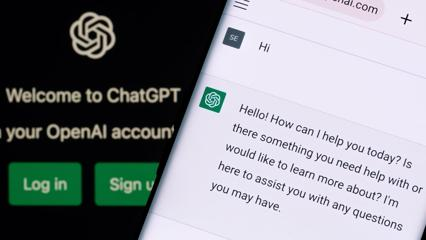

[ChatGPT adds better charting and advanced data analysis.](https://mashable.com/article/chatgpt-charts-tables-google-drive) - Mashable

___

[My advice 
- Write down the intent of the prompt in your own words
- Take a crack at a prompt using a checklist, like druce.ai/2024/01/prom...
- Search the web for similar prompts and improve it
- Last, tell chatgpt to improve the prompt, clarify it and expand it, using a GPT like Prompt Professor](https://druce.ai/2024/01/prompting) - Druce.ai

___

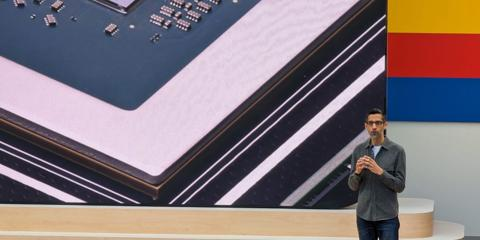

[Summarizing Google's prompt engineering advice using a prompt.](https://www.businessinsider.com/google-how-to-write-best-ai-prompt-guide-101-gemini-2024-5) - Business Insider

___

[The race for an AI-powered personal assistant](https://www.ft.com/content/8772d32b-99df-497f-9bd7-4244f38d0439)

___

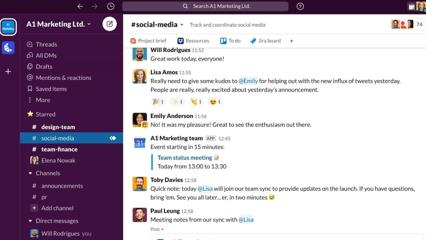

[Slack gets big user backlash over training AI models on user content.](https://www.pcmag.com/news/slack-trains-ai-powered-features-on-user-messages-files) - PCMAG

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 5, 20, 13, 23, 44, 945000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-05-19 03:25:09.395116
